# Testing Cuda and installing packages

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is correctly set up

True


In [ ]:
!pip install datasets transformers huggingface_hub supervision timm flash_attn sentence_transformers open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [ ]:
!git lfs clone https://huggingface.co/datasets/sammarfy/VLM4Bio VLM4BIO_data

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'VLM4BIO_data'...
remote: Enumerating objects: 31716, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 31716 (delta 0), reused 0 (delta 0), pack-reused 31711 (from 1)
Receiving objects: 100% (31716/31716), 269.51 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (31484/31484), done.


In [ ]:
!mkdir downloaded_images

!mv VLM4BIO_data/datasets/Bird/chunk_0/* downloaded_images
!mv VLM4BIO_data/datasets/Bird/chunk_1/* downloaded_images
!mv VLM4BIO_data/datasets/Bird/chunk_2/* downloaded_images
!mv VLM4BIO_data/datasets/Bird/chunk_3/* downloaded_images
!mv VLM4BIO_data/datasets/Bird/chunk_4/* downloaded_images

!mv VLM4BIO_data/datasets/Butterfly/chunk_0/* downloaded_images
!mv VLM4BIO_data/datasets/Butterfly/chunk_1/* downloaded_images
!mv VLM4BIO_data/datasets/Butterfly/chunk_2/* downloaded_images
!mv VLM4BIO_data/datasets/Butterfly/chunk_3/* downloaded_images
!mv VLM4BIO_data/datasets/Butterfly/chunk_4/* downloaded_images

!mv VLM4BIO_data/datasets/Fish/chunk_0/* downloaded_images
!mv VLM4BIO_data/datasets/Fish/chunk_1/* downloaded_images
!mv VLM4BIO_data/datasets/Fish/chunk_2/* downloaded_images
!mv VLM4BIO_data/datasets/Fish/chunk_3/* downloaded_images
!mv VLM4BIO_data/datasets/Fish/chunk_4/* downloaded_images

# Importing packages and downloading/cleaning data

In [ ]:
import os
import pandas as pd
import requests
import torch
from transformers import AutoModelForCausalLM, AutoProcessor
from PIL import Image
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Step 1: Download the metadata CSV if it doesn't already exist
def download_metadata_csv(metadata_url, metadata_file_path):
    if not os.path.exists(metadata_file_path):
        response = requests.get(metadata_url)
        if response.status_code == 200:
            with open(metadata_file_path, 'wb') as f:
                f.write(response.content)
            print(f"Metadata CSV file saved as {metadata_file_path}")
        else:
            print(f"Failed to download the metadata file. Status code: {response.status_code}")
            return
    else:
        print(f"Metadata file already exists at {metadata_file_path}")

# Step 2: Convert the metadata CSV file to DataFrame
def convert_metadata_to_dataframe(metadata_file_path):
    df = pd.read_csv(metadata_file_path)
    df.rename(columns={"fileNameAsDelivered": "image_filename", "scientificName": "scientificName"}, inplace=True)
    return df

# Step 3: Download images from the specified chunks
def download_images(df, chunk_base_url, chunk_count, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for _, row in df.iterrows():
        image_filename = row['image_filename']
        image_downloaded = False
        for chunk_index in range(chunk_count):
            image_url = f"{chunk_base_url}chunk_{chunk_index}/{image_filename}"
            response = requests.get(image_url)
            if response.status_code == 200:
                image_path = os.path.join(output_dir, image_filename)
                with open(image_path, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded and saved: {image_filename} from chunk_{chunk_index}")
                image_downloaded = True
                break
            else:
                print(f"Image not found in chunk_{chunk_index}: {image_filename}")
        if not image_downloaded:
            print(f"Failed to download {image_filename} from all chunks.")

# Step 4: Filter existing images and remove missing records
def filter_existing_images_with_scientific_name(df, output_dir, taxa='Fish'):
    df['file_exists'] = df['image_filename'].apply(lambda x: os.path.exists(os.path.join(output_dir, x)))
    df_cleaned = df[df['file_exists']].copy()
    df_cleaned.drop(columns=['file_exists'], inplace=True)
    df_cleaned['taxa'] = taxa
    return df_cleaned

# Step 5: Save the DataFrame to CSV
def save_dataframe_to_csv(df, csv_file_path="cleaned_images_with_scientific_names.csv"):
    df.to_csv(csv_file_path, index=False)
    print(f"DataFrame saved to {csv_file_path}")


taxa = ['Fish', 'Bird', 'Butterfly']
cleaned_dfs = []
for t in taxa:
  # Main execution
  metadata_url = f"https://huggingface.co/datasets/sammarfy/VLM4Bio/resolve/main/datasets/{t}/metadata/metadata_easy.csv" # so far easy, but not enough datasets for everyone
  metadata_file_path = f"metadata_easy_{t}.csv"
  output_dir = "downloaded_images"
  # chunk_base_url = f"https://huggingface.co/datasets/sammarfy/VLM4Bio/resolve/main/datasets/{t}/"
  # chunk_count = 5  # We have chunk_0 to chunk_4

  # Execute steps
  download_metadata_csv(metadata_url, metadata_file_path)
  df = convert_metadata_to_dataframe(metadata_file_path)
  # download_images(df, chunk_base_url, chunk_count, output_dir)
  df_cleaned = filter_existing_images_with_scientific_name(df, output_dir, t)
  cleaned_dfs.append(df_cleaned)
  save_dataframe_to_csv(df_cleaned, f"cleaned_images_with_scientific_names_{t}.csv")


# Get unique labels from df["scientific_name"]
labels = df_cleaned["scientificName"].unique().tolist()
full_species_df = pd.concat(cleaned_dfs)

full_species_df = full_species_df.dropna(subset=['scientificName'])
full_species_df = full_species_df[full_species_df['scientificName'].str.strip() != '']


Metadata CSV file saved as metadata_easy_Fish.csv
DataFrame saved to cleaned_images_with_scientific_names_Fish.csv
Metadata CSV file saved as metadata_easy_Bird.csv
DataFrame saved to cleaned_images_with_scientific_names_Bird.csv
Metadata CSV file saved as metadata_easy_Butterfly.csv
DataFrame saved to cleaned_images_with_scientific_names_Butterfly.csv


In [ ]:
full_species_df

,image_filename,scientificName,taxa
0,UWZM-F-0001570.JPG,Lepomis macrochirus,Fish
1,UWZM-F-0001664.JPG,Lepomis megalotis,Fish
2,UWZM-F-0001696.JPG,Lepomis microlophus,Fish
3,UWZM-F-0001697.JPG,Lepomis punctatus,Fish
4,UWZM-F-0000002.JPG,Alosa aestivalis,Fish
...,...,...,...
10008,Butterfly_imbalanced_test_Eueides_isabella_114...,Eueides isabella,Butterfly
10009,Butterfly_imbalanced_test_Eueides_isabella_980...,Eueides isabella,Butterfly
10010,Butterfly_imbalanced_test_Rhetus_periander_307...,Rhetus periander,Butterfly
10011,Butterfly_imbalanced_test_Rhetus_periander_371...,Rhetus periander,Butterfly


In [ ]:
import open_clip
from transformers import AutoModel, CLIPImageProcessor
from huggingface_hub import hf_hub_download

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

def get_model(model_name):
  if model_name == 'florence':
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True)
    processing = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
  elif model_name == 'bioclip':
    model, _, processing = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
  elif model_name == 'arborclip':
    model_name = "ChihHsuan-Yang/ArborCLIP"
    filename = "arborclip-vit-b-16-from-bioclip-epoch-8.pt"

    # Download the file from the repository
    weights_path = hf_hub_download(repo_id=model_name, filename=filename)

    # Initialize the base BioCLIP model using OpenCLIP
    model, _, processing = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')

    # Load the fine-tuned weights into the model
    checkpoint = torch.load(weights_path, map_location='cpu')

    if "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint

    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
  elif model_name == 'internvl':
    model = AutoModel.from_pretrained(
        'OpenGVLab/InternViT-300M-448px',
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        trust_remote_code=True).cuda().eval()

    processing = CLIPImageProcessor.from_pretrained('OpenGVLab/InternViT-300M-448px')
  else:
    model, _, processing = open_clip.create_model_and_transforms(
      "ViT-B-32", pretrained="laion2b_s34b_b79k", device=device)

  model.to(device)
  model = model.eval()
  return model, processing


# Loading Models

In [ ]:
def get_image_embeddings_florence(image_filename, model, processor):

    # folder where images are stored
    image_folder = "downloaded_images"

    try:
        # Create the full image path by combining the folder and filename
        image_path = os.path.join(image_folder, image_filename)

        # Open the image
        image = Image.open(image_path)

        # Prepare inputs using the processor
        inputs = processor(images=image, return_tensors="pt").to(device)

        # Ensure inputs are converted to float16 if using mixed precision
        inputs = {k: v.to(dtype=torch.float16) if model.dtype == torch.float16 else v for k, v in inputs.items()}

        # Get image embeddings using the private method
        with torch.no_grad():  # Avoid computing gradients since we are not training
            image_embeddings = model._encode_image(inputs["pixel_values"])

        # Convert embeddings to CPU tensor (to avoid keeping them on GPU)
        return image_embeddings.cpu().numpy()

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None  # Return None for failed image processing

def get_image_embeddings_clip(image_filename, model, preprocess):
    # folder where images are stored
    image_folder = "downloaded_images"

    try:
        image_path = os.path.join(image_folder, image_filename)
        image = Image.open(image_path)
        image = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_embeddings = model.encode_image(image)

        return image_embeddings.cpu().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None  # Return None for failed image processing

def get_image_embeddings_intern(image_filename, model, preprocess):
    image_folder = "downloaded_images"

    try:
        image_path = os.path.join(image_folder, image_filename)
        image = Image.open(image_path).convert('RGB')
        pixel_values = preprocess(images=image, return_tensors='pt').pixel_values

        with torch.no_grad():
            pixel_values = pixel_values.to(torch.bfloat16).cuda()
            image_embeddings = model(pixel_values).pooler_output
        return image_embeddings.to(torch.float32).cpu().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None  # Return None for failed image processing


# Test/Train split, stratification option available

In [ ]:
from sklearn.model_selection import train_test_split

def get_test_train_split(df_cleaned, test_size=0.1, stratify_by_scientific_name=False):
  if stratify_by_scientific_name:
    # if we want to get at least one from each we can filter out all options with only 1 image
    species_counts = df_cleaned['scientificName'].value_counts()
    valid_species = species_counts[species_counts > 1].index
    df_filtered = df_cleaned[df_cleaned['scientificName'].isin(valid_species)]
    # with stratification, we need to specify the test_size because we need to hit a minimum
    calc_min = len(valid_species)/len(df_filtered)
    min_split = max(test_size, calc_min)
    print(f'The split for stratification is: {min_split}')

    train_df, test_df = train_test_split(df_filtered, test_size=min_split, stratify=df_filtered['scientificName'])
  else:
    train_df, test_df = train_test_split(df_cleaned, test_size=test_size)
  return train_df, test_df

# train_df, test_df = get_test_train_split(df_cleaned, stratify_by_scientific_name=True)


# Cosine Similarity & Euclidean Distance metrics calculations (non-vectorized)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd

# Function to calculate cosine similarity between two 3D embeddings
def calculate_similarity(embedding1, embedding2, model):
    # Average across the token dimension (axis=1) to get a single vector
    if model == 'florence':
      embedding1_avg = np.mean(embedding1, axis=1)
      embedding2_avg = np.mean(embedding2, axis=1)
    else:
      embedding1_avg, embedding2_avg = embedding1, embedding2

    # Calculate cosine similarity between the averaged embeddings
    # print('shapes', embedding1_avg.shape, embedding2_avg.shape)

    similarity = cosine_similarity(embedding1_avg, embedding2_avg)
    # print(similarity)
    return similarity[0][0]

# function to calculate euclidena distance between two 3D embeddings
def calculate_distance(embedding1, embedding2, model):
    if model == 'florence':
      embedding1_avg = np.mean(embedding1, axis=1)
      embedding2_avg = np.mean(embedding2, axis=1)
    else:
      embedding1_avg, embedding2_avg = embedding1, embedding2

    distance = euclidean_distances(embedding1_avg, embedding2_avg)
    return distance[0][0]

def find_best_match(test_embedding, train_df, label_column, model):
    similarities = []
    distances = []

    # Loop through each image in the train set and calculate similarity
    for idx, row in train_df.iterrows():
        similarity_score = calculate_similarity(np.array(test_embedding), np.array(row['image_embeddings']), model)
        distance_score = calculate_distance(np.array(test_embedding), np.array(row['image_embeddings']), model)
        similarities.append((row[label_column], similarity_score))
        distances.append((row[label_column], distance_score))

    # Create a DataFrame from similarities to easily group and process
    similarity_df = pd.DataFrame(similarities, columns=[label_column, 'similarity_score'])

    distance_df = pd.DataFrame(distances, columns=[label_column, 'distance_score'])

    # Group by the label column
    sim_grouped = similarity_df.groupby(label_column)

    # Column 1: Highest cosine similarity per label
    sim_highest_scores = sim_grouped['similarity_score'].max()

    # Column 2: Sum of cosine similarities per label
    sim_mean_scores = sim_grouped['similarity_score'].mean()

    # Find the label with the highest summed score
    sim_highest_mean_label = sim_mean_scores.idxmax()
    sim_highest_mean_score = sim_mean_scores.max() # is each summed score normalized?

    # Find the label with the highest individual cosine score
    sim_highest_individual_label = sim_highest_scores.idxmax()
    sim_highest_individual_score = sim_highest_scores.max()

    return sim_highest_individual_label, sim_highest_individual_score, sim_highest_mean_label, sim_highest_mean_score

def apply_best_match(test_df, train_df, label_column, model):
    # Apply the process to each image in the test set
    test_df[['highest_individual_name', 'highest_individual_score',
             'highest_mean_name', 'highest_mean_score']] = test_df['image_embeddings'].apply(
        lambda x: pd.Series(find_best_match(np.array(x), train_df, label_column, model))
    )

    # Check accuracy by comparing the predicted highest label with the actual label in the test set
    accuracy_individual = np.mean(test_df['highest_individual_name'] == test_df[label_column])
    accuracy_mean = np.mean(test_df['highest_mean_name'] == test_df[label_column])

    print(f"Accuracy for model {model} on column {label_column} based on highest individual cosine similarity: {accuracy_individual * 100:.2f}%")
    print(f"Accuracy for model {model} on column {label_column} based on highest mean cosine similarity: {accuracy_summed * 100:.2f}%")

    return test_df, accuracy_individual, accuracy_mean

# Example usage:
# apply_best_match(test_df, train_df, 'scientificName', model)

# Cosine Similarity & Euclidean Distance metrics calculations (vectorized)

In [ ]:
def calculate_similarity_and_distance(test_embeddings, train_embeddings, model):

    # we don't need the dim=1, in both cases its 1
    test_embeddings, train_embeddings = np.squeeze(test_embeddings, axis=1), np.squeeze(train_embeddings, axis=1)

    # if florence, avg across new dim 1, size = 577 (patches on img)
    if model == 'florence':
        test_embeddings = np.mean(test_embeddings, axis=1)
        train_embeddings = np.mean(train_embeddings, axis=1)

    similarity_matrix = cosine_similarity(test_embeddings, train_embeddings)
    distance_matrix = euclidean_distances(test_embeddings, train_embeddings)

    return similarity_matrix, distance_matrix


def find_best_match_vectorized(test_embeddings, train_df, label_column, model):
    # Get train embeddings and labels as numpy arrays
    train_embeddings = np.array(train_df['image_embeddings'].tolist())
    train_labels = train_df[label_column].values

    # Calculate similarity and distance for all test embeddings at once
    similarity_matrix, distance_matrix = calculate_similarity_and_distance(test_embeddings, train_embeddings, model)

    # Get the labels with the highest individual similarity score and lowest distance
    highest_similarity_idx = similarity_matrix.argmax(axis=1)
    highest_similarity_labels = train_labels[highest_similarity_idx]
    highest_similarity_scores = similarity_matrix.max(axis=1)

    lowest_dist_idx = distance_matrix.argmin(axis=1)
    lowest_dist_labels = train_labels[highest_similarity_idx]
    lowest_dist_scores = similarity_matrix.min(axis=1)

    # create a repeated matrix of train labels to match the size of similarity matrix (test_size x train_size)
    repeated_train_labels = np.tile(train_labels, (similarity_matrix.shape[0], 1))

    # Create a DataFrame with each test embedding's comparison to all train labels
    # Flatten the similarity matrix and repeated labels to match
    similarity_df = pd.DataFrame({
        'test_idx': np.repeat(range(similarity_matrix.shape[0]), similarity_matrix.shape[1]),
        label_column: repeated_train_labels.flatten(),
        'similarity_score': similarity_matrix.flatten()
    })
    avg_similarity_df = similarity_df.groupby(['test_idx', label_column], as_index=False).mean()
    idx_max_avg = avg_similarity_df.groupby('test_idx')['similarity_score'].idxmax()
    highest_avg_sim_labels = avg_similarity_df.loc[idx_max_avg, label_column].values
    highest_avg_sim_scores = avg_similarity_df.loc[idx_max_avg, 'similarity_score'].values

    distance_df = pd.DataFrame({
        'test_idx': np.repeat(range(similarity_matrix.shape[0]), similarity_matrix.shape[1]),
        label_column: repeated_train_labels.flatten(),
        'distance_score': distance_matrix.flatten()
    })
    avg_dist_df = distance_df.groupby(['test_idx', label_column], as_index=False).mean()
    idx_min_avg = avg_dist_df.groupby('test_idx')['distance_score'].idxmin()
    lowest_avg_dist_labels = avg_dist_df.loc[idx_min_avg, label_column].values
    lowest_avg_dist_scores = avg_dist_df.loc[idx_min_avg, 'distance_score'].values

    return highest_similarity_labels,highest_similarity_scores,highest_avg_sim_labels,highest_avg_sim_scores,lowest_dist_labels,lowest_dist_scores,lowest_avg_dist_labels,lowest_avg_dist_scores

def apply_best_match_vectorized(test_df, train_df, label_column, model):
    # Convert all test image embeddings to numpy arrays
    test_embeddings = np.array(test_df['image_embeddings'].tolist())

    # Vectorized function to find the best match for each test embedding
    highest_individual_name, highest_individual_score, highest_mean_name, highest_mean_score,lowest_dist_name, lowest_dist_score, lowest_avg_dist_name, lowest_avg_dist_score = find_best_match_vectorized(
        test_embeddings, train_df, label_column, model
    )

    # Assign results back to the test DataFrame
    test_df['highest_individual_name'] = highest_individual_name
    test_df['highest_individual_score'] = highest_individual_score
    test_df['highest_mean_name'] = highest_mean_name
    test_df['highest_mean_score'] = highest_mean_score
    test_df['lowest_dist_name'] = lowest_dist_name
    test_df['lowest_dist_score'] = lowest_dist_score
    test_df['lowest_avg_dist_name'] = lowest_avg_dist_name
    test_df['lowest_avg_dist_score'] = lowest_avg_dist_score

    # Calculate accuracy metrics
    accuracy_individual = np.mean(test_df['highest_individual_name'] == test_df[label_column])
    accuracy_mean = np.mean(test_df['highest_mean_name'] == test_df[label_column])
    accuracy_dist = np.mean(test_df['lowest_dist_name'] == test_df[label_column])
    accuracy_avg_dist = np.mean(test_df['lowest_avg_dist_name'] == test_df[label_column])

    print(f"Accuracy for model {model} on column {label_column} based on highest individual cosine similarity: {accuracy_individual * 100:.2f}%")
    print(f"Accuracy for model {model} on column {label_column} based on highest mean cosine similarity: {accuracy_mean * 100:.2f}%")
    print(f"Accuracy for model {model} on column {label_column} based on lowest individual euclidean distance: {accuracy_individual * 100:.2f}%")
    print(f"Accuracy for model {model} on column {label_column} based on lowest mean euclidean distance: {accuracy_mean * 100:.2f}%")

    return test_df, accuracy_individual, accuracy_mean, accuracy_dist, accuracy_avg_dist



In [ ]:
# Function to extract the genus from the scientific name (first part before space)
def extract_genus(scientific_name):
    try:
      return scientific_name.split()[0]
    except Exception as e:
      print(scientific_name)
      raise


# Model eval run for all models (if running full dataset on florence, A100 is reuqired)

In [ ]:
import time

models = ['florence', 'clip', 'bioclip', 'arborclip', 'internvl']
analysis_taxa = ['Fish', 'Bird', 'Butterfly', 'All']
eval_df = pd.DataFrame(columns=['model', 'taxa', 'column', 'accuracy_individual', 'accuracy_avg', 'distance_individual',	'distance_avg'])
rows = []
time_dict = {m: {'embedding': 0, 'analysis': 0} for m in models}
embedding_func = {'florence': get_image_embeddings_florence, 'internvl': get_image_embeddings_intern}

full_species_df = full_species_df[full_species_df['scientificName'].str.strip() != '']
full_species_df['genus'] = full_species_df['scientificName'].apply(extract_genus)

for model_name in models:
  print(f"WORKING ON MODEL: {model_name}")
  model, processing = get_model(model_name)

  # note the amount of time necessary to generate all embeddings
  start = time.time()
  get_image_embeddings = embedding_func.get(model_name, get_image_embeddings_clip)
  full_species_df['image_embeddings'] = full_species_df['image_filename'].apply(lambda x: get_image_embeddings(x, model, processing))
  full_species_df.dropna(subset=['scientificName'], inplace=True)
  time_length = time.time() - start
  print(f"Time to get embeddings for model {model_name}: {time_length}")
  time_dict[model_name]['embedding'] = time_length

  # we're gonna compare species by species within each taxa, and against each
  for taxa in analysis_taxa: # cleaned_dfs can have full species appended to it too
    print(f"WORKING ON TAXA: {taxa}")

    df = full_species_df if taxa == 'All' else full_species_df[full_species_df['taxa'] == taxa]
    train_df, test_df = get_test_train_split(df, test_size=0.1, stratify_by_scientific_name=True)

    start = time.time()
    test_df, accuracy_individual, accuracy_avg, distance_individual, distance_avg = apply_best_match_vectorized(test_df, train_df, 'scientificName', model_name)
    time_length = time.time() - start
    print(f"Time for analysis for model {model_name}: {time_length}")
    rows.append({'model': model_name, 'taxa': taxa, 'column': 'species', 'accuracy_individual': f"{accuracy_individual * 100:.2f}%", 'accuracy_avg': f"{accuracy_avg * 100:.2f}%", 'distance_individual': f"{distance_individual * 100:.2f}%", 'distance_avg': f"{distance_avg * 100:.2f}%"})
    time_dict[model_name]['analysis'] = time_length

    test_df, accuracy_individual, accuracy_avg, distance_individual, distance_avg = apply_best_match_vectorized(test_df, train_df, 'genus', model_name)
    rows.append({'model': model_name, 'taxa': taxa, 'column': 'genus', 'accuracy_individual': f"{accuracy_individual * 100:.2f}%", 'accuracy_avg': f"{accuracy_avg * 100:.2f}%", 'distance_individual': f"{distance_individual * 100:.2f}%", 'distance_avg': f"{distance_avg * 100:.2f}%"})
    if taxa == 'All': # only relevant when comparing against other taxa
      test_df, accuracy_individual, accuracy_avg, distance_individual, distance_avg = apply_best_match_vectorized(test_df, train_df, 'taxa', model_name)
      rows.append({'model': model_name, 'taxa': taxa, 'column': 'taxa', 'accuracy_individual': f"{accuracy_individual * 100:.2f}%", 'accuracy_avg': f"{accuracy_avg * 100:.2f}%", 'distance_individual': f"{distance_individual * 100:.2f}%", 'distance_avg': f"{distance_avg * 100:.2f}%"})

eval_df = pd.concat([eval_df, pd.DataFrame(rows)], ignore_index=True)
eval_df


WORKING ON MODEL: florence


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time to get embeddings for model florence: 60.18302059173584
WORKING ON TAXA: Fish
The split for stratification is: 0.14367816091954022
Accuracy for model florence on column scientificName based on highest individual cosine similarity: 68.00%
Accuracy for model florence on column scientificName based on highest mean cosine similarity: 48.00%
Accuracy for model florence on column scientificName based on lowest individual euclidean distance: 68.00%
Accuracy for model florence on column scientificName based on lowest mean euclidean distance: 48.00%
Time for analysis for model florence: 0.4017612934112549
Accuracy for model florence on column genus based on highest individual cosine similarity: 88.00%
Accuracy for model florence on column genus based on highest mean cosine similarity: 76.00%
Accuracy for model florence on column genus based on lowest individual euclidean distance: 88.00%
Accuracy for model florence on column genus based on lowest mean euclidean distance: 76.00%
WORKING ON 

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loc

Time to get embeddings for model clip: 13.750793218612671
WORKING ON TAXA: Fish
The split for stratification is: 0.14367816091954022
Accuracy for model clip on column scientificName based on highest individual cosine similarity: 64.00%
Accuracy for model clip on column scientificName based on highest mean cosine similarity: 40.00%
Accuracy for model clip on column scientificName based on lowest individual euclidean distance: 64.00%
Accuracy for model clip on column scientificName based on lowest mean euclidean distance: 40.00%
Time for analysis for model clip: 0.018510818481445312
Accuracy for model clip on column genus based on highest individual cosine similarity: 84.00%
Accuracy for model clip on column genus based on highest mean cosine similarity: 76.00%
Accuracy for model clip on column genus based on lowest individual euclidean distance: 84.00%
Accuracy for model clip on column genus based on lowest mean euclidean distance: 76.00%
WORKING ON TAXA: Bird
The split for stratificati

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loc

Time to get embeddings for model bioclip: 13.656785011291504
WORKING ON TAXA: Fish
The split for stratification is: 0.14367816091954022
Accuracy for model bioclip on column scientificName based on highest individual cosine similarity: 72.00%
Accuracy for model bioclip on column scientificName based on highest mean cosine similarity: 56.00%
Accuracy for model bioclip on column scientificName based on lowest individual euclidean distance: 72.00%
Accuracy for model bioclip on column scientificName based on lowest mean euclidean distance: 56.00%
Time for analysis for model bioclip: 0.017591476440429688
Accuracy for model bioclip on column genus based on highest individual cosine similarity: 92.00%
Accuracy for model bioclip on column genus based on highest mean cosine similarity: 84.00%
Accuracy for model bioclip on column genus based on lowest individual euclidean distance: 92.00%
Accuracy for model bioclip on column genus based on lowest mean euclidean distance: 84.00%
WORKING ON TAXA: B

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loc

Time to get embeddings for model arborclip: 13.72331714630127
WORKING ON TAXA: Fish
The split for stratification is: 0.14367816091954022
Accuracy for model arborclip on column scientificName based on highest individual cosine similarity: 76.00%
Accuracy for model arborclip on column scientificName based on highest mean cosine similarity: 76.00%
Accuracy for model arborclip on column scientificName based on lowest individual euclidean distance: 76.00%
Accuracy for model arborclip on column scientificName based on lowest mean euclidean distance: 76.00%
Time for analysis for model arborclip: 0.013537883758544922
Accuracy for model arborclip on column genus based on highest individual cosine similarity: 96.00%
Accuracy for model arborclip on column genus based on highest mean cosine similarity: 96.00%
Accuracy for model arborclip on column genus based on lowest individual euclidean distance: 96.00%
Accuracy for model arborclip on column genus based on lowest mean euclidean distance: 96.00%

,model,taxa,column,accuracy_individual,accuracy_avg,distance_individual,distance_avg
0,florence,Fish,species,68.00%,48.00%,68.00%,52.00%
1,florence,Fish,genus,88.00%,76.00%,88.00%,76.00%
2,florence,Bird,species,47.62%,35.71%,47.62%,33.33%
3,florence,Bird,genus,78.57%,76.19%,78.57%,76.19%
4,florence,Butterfly,species,72.73%,77.27%,72.73%,77.27%
5,florence,Butterfly,genus,90.91%,77.27%,90.91%,77.27%
6,florence,All,species,62.92%,53.93%,62.92%,50.56%
7,florence,All,genus,88.76%,84.27%,88.76%,84.27%
8,florence,All,taxa,100.00%,100.00%,100.00%,100.00%
9,clip,Fish,species,64.00%,40.00%,64.00%,36.00%


In [ ]:
# save df to csv
eval_df.to_csv('eval_df.csv')

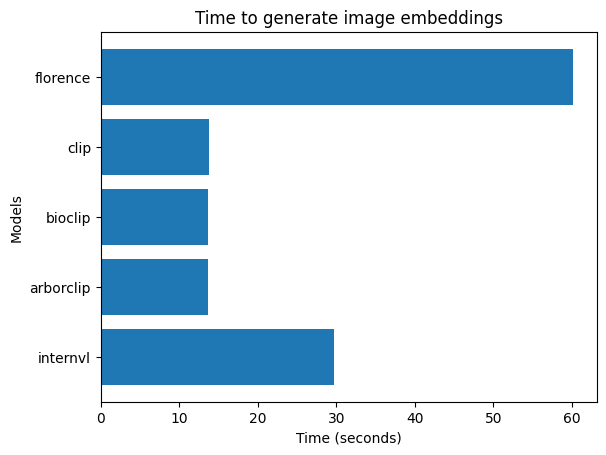

In [ ]:
# make comparison chart for evaluation times across models

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Example data
models = list(models)
y_pos = np.arange(len(models))
embedding = [time_dict[m]['embedding'] for m in models]
analysis = [time_dict[m]['analysis'] for m in models]

ax.barh(models, embedding, align='center')
ax.set_yticks(y_pos, labels=models)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Models')
ax.set_title('Time to generate image embeddings')

plt.show()


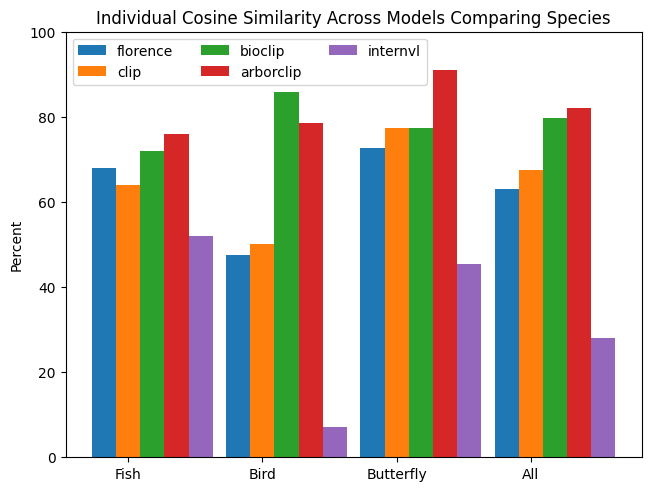

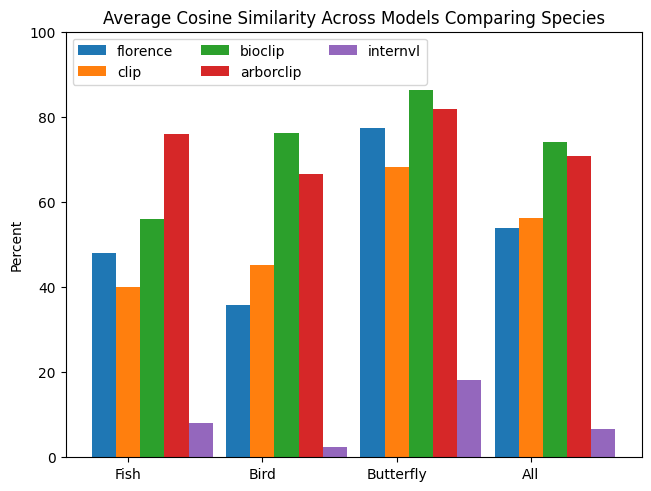

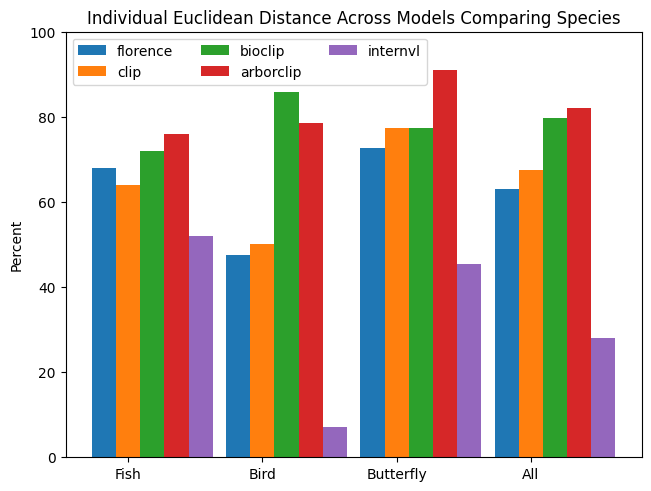

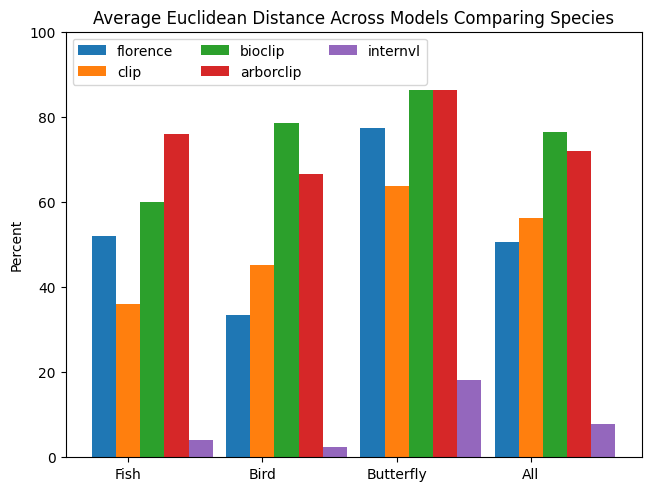

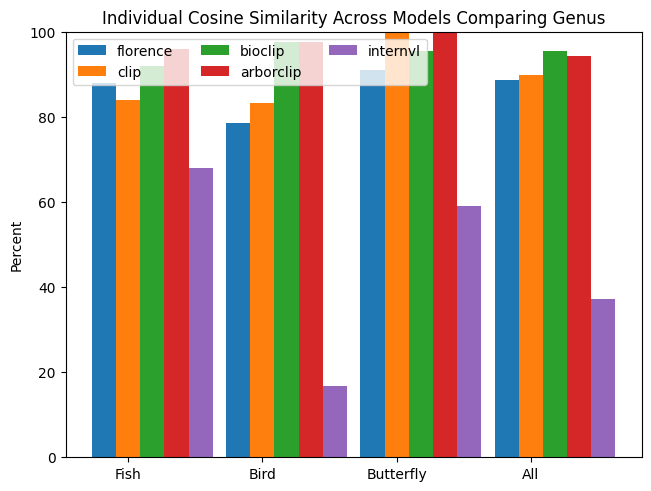

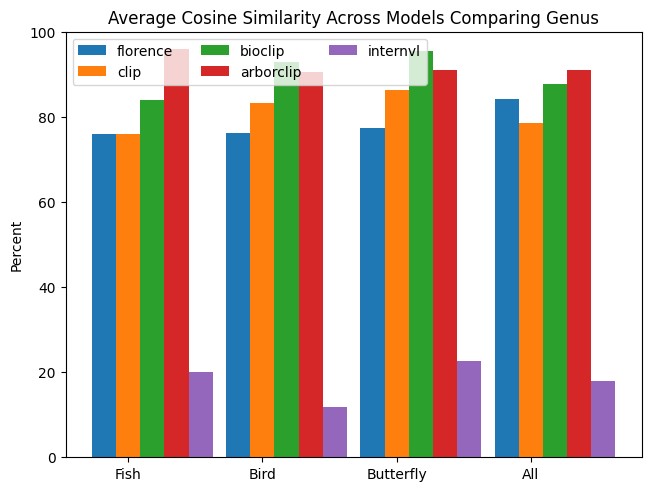

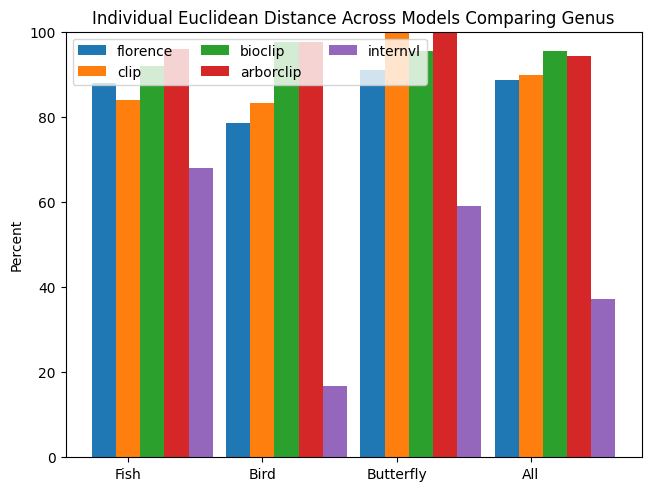

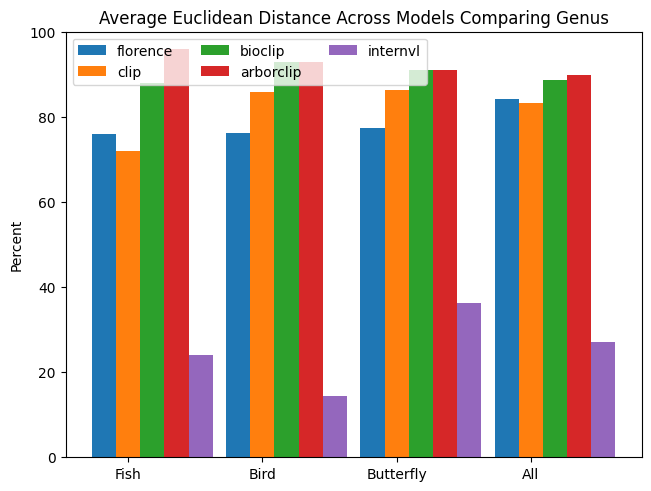

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = eval_df

species_rows = df[(df['column'] == 'species')]
genus_rows = df[(df['column'] == 'genus')]

# create comparative bar plots to show cosine similarity & euclid. distance
# across all models for all taxa
def make_plot(comparison_metric, df, column = 'species'):
  if comparison_metric == 'cosine':
    col1, col2 = 'accuracy_individual', 'accuracy_avg'
    title1, title2 = 'Individual Cosine Similarity', 'Average Cosine Similarity'
  elif comparison_metric == 'distance':
    col1, col2 = 'distance_individual', 'distance_avg'
    title1, title2 = 'Individual Euclidean Distance', 'Average Euclidean Distance'
  else:
    print('comparison metric is either distance or cosine')

  taxa = list(df['taxa'].unique())
  models = list(df['model'].unique())

  model_ind = {
      m: list(df.loc[df['model'] == m, col1].str.replace('%', '').astype(float)) for m in models
  }
  model_mean = {
      m: list(df.loc[df['model'] == m, col2].str.replace('%', '').astype(float)) for m in models
  }

  x = np.arange(len(taxa))  # the label locations
  width = 0.18  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained')

  for model, measurement in model_ind.items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=model)
      multiplier += 1

  ax.set_ylabel('Percent')
  ax.set_title(f"{title1} Across Models Comparing {column.title()}")
  ax.set_xticks(x + width, taxa)
  ax.legend(loc='upper left', ncols=3)
  ax.set_ylim(0, 100)

  plt.show()

  fig, ax = plt.subplots(layout='constrained')
  multiplier = 0
  for model, measurement in model_mean.items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=model)
      multiplier += 1
  ax.set_ylabel('Percent')
  ax.set_title(f"{title2} Across Models Comparing {column.title()}")
  ax.set_xticks(x + width, taxa)
  ax.legend(loc='upper left', ncols=3)
  ax.set_ylim(0, 100)
  plt.show()

make_plot('cosine', species_rows, column='species')
make_plot('distance', species_rows, column='species')
make_plot('cosine', genus_rows, column='genus')
make_plot('distance', genus_rows, column='genus')